In [1]:
import json
import os
from os import listdir
from os.path import isfile, join, isdir
import pickle
import gzip
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D

import tabulate
import numpy as np
import math

from itertools import cycle, islice


from collect_data import collect_statistics

In [2]:
fig_width = 8
fig_height = 5

params = {
    'axes.labelsize': 16, # fontsize for x and y labels (was 10)
    'axes.titlesize': 16,
    'legend.fontsize': 16, # was 10
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    #'text.usetex': True,
    'figure.figsize': [fig_width,fig_height],
    'font.family': 'serif',
    'grid.linestyle': '--',
    'lines.linewidth': 2
}

matplotlib.rcParams.update(params)

In [3]:
out_dir = join('..', 'plots', 'parallelization_exp')

In [4]:
def my_3d_plot(x, y, values, plot_name, z_lim=None, save_dir=None):
    y_offset = 5
    
    # prepare data   
    X, Y = np.meshgrid(x, y)
    Z = np.transpose(np.array(values))
    
    
    fig = plt.figure()
    ax = Axes3D(fig)
      
    # plot the data
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, linewidth=0, antialiased=True)
    
    # add contour lines for readability
    print(np.min(values[0]))
    min_index = np.argmin(values[0])
    max_index = np.argmax(values[0])
    
    median_index = list(values[0]).index(np.percentile(values[0], 50, interpolation='nearest'))

    print(median_index)
    lvls = [min_index, median_index, max_index]
    colors = ['darkslateblue', 'forestgreen', 'indianred']
    temp = list(zip(lvls, colors))
    temp.sort(key=lambda x: x[0])
    display(temp)
    lvls, colors = zip(*temp)
    display(lvls)
    display(colors)
    
    # TODO: 40 is not displayed properly
    if lvls[2] == 40:
        lvls = list(lvls)
        lvls[2] = 39
    #lvls = [20,30,39]
    cset = ax.contour(X, Y, Z, zdir='y', levels=lvls, offset=-y_offset, colors=colors)

    ax.zaxis.set_major_formatter(FormatStrFormatter('%.0f'))

    #fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.title(plot_name)
    plt.xticks(x)
    ax.view_init(30, 25)
    
    if z_lim:
        ax.set_zlim([0, z_lim])

    #ax.set_ylim([-y_offset, len(y)+y_offset])
    ax.set_ylim([-y_offset, len(y)+y_offset])
    
    ax.set_xlabel("Available cores", labelpad=10)
    ax.set_ylabel("GDB version", labelpad=10)

    ax.zaxis.set_rotate_label(False)  # disable automatic rotation
    ax.set_zlabel("Duration (minutes)", rotation=90, labelpad=10)
    
    #fig.colorbar.remove()
    
    if save_dir:
        plt.savefig(save_dir + '/' + plot_name.replace(' ', '-') + '-parallel.pdf',  bbox_inches='tight')
        plt.savefig(save_dir + '/' + plot_name.replace(' ', '-') + '-parallel.png',  bbox_inches='tight', dpi=300)
        
    plt.show()


def plot_all(appname, collections, parallizations, performance_frame):
    for collection in collections:
        values_incr = []
        values_batch = []
        for parallelization in parallizations:
            values_incr.append(np.array(performance_frame[collection+'-'+parallelization+'-Inc']))
            values_batch.append(np.array(performance_frame[collection+'-'+parallelization+'-Batch']))


        x = [int(x.replace('parallel_', '')) for x in parallizations]
        y = np.arange(0, len(performance_frame), 1) # 41

        z_lim = performance_frame.max().max()
        z_lim += z_lim/10
        z_lim = 5 * round(z_lim/5)

        #my_3d_plot(x, y, values_incr, '%s %s Incr' % (appname, collection), z_lim=60, save_dir=out_dir)
        my_3d_plot(x, y, values_incr, '%s %s Incr' % (appname, collection), save_dir=out_dir)

        #my_3d_plot(x, y, values_batch, '%s %s Batch' % (appname, collection), z_lim=60, save_dir=out_dir)
        my_3d_plot(x, y, values_batch, '%s %s Batch' % (appname, collection), save_dir=out_dir)


    #     for angle in range(0, 360):
    #         ax.view_init(30, angle)
    #         plt.draw()
    #         plt.pause(.001)


In [5]:
def load_data(app_name, collection, parallelization, suffix, event_dir, memory_dir,
              exp_log_dir=None, performance_frame=pd.DataFrame(), run_details_frame=pd.DataFrame()):
    
    """
    event_dir and memory_dir are global
    performance_frame and run_details_frame are global
    """
    if exp_log_dir:
        app_exp_name = app_name + '-' + collection + '-' + parallelization + suffix
        print('load %s from csv' % app_exp_name)
        
        with open(os.path.join(exp_log_dir, app_exp_name, app_exp_name+'-performance.csv'), 'r') as f:
            df = pd.read_csv(f, sep=',')
#             iterations = max(iterations, len(df['Iteration']))
            df = df.set_index('Iteration')
    else:
        exp_name = app_name + '-' + collection + '-' + parallelization + suffix

        print('collect %s from logs' % exp_name)
        df = collect_statistics(exp_name, event_dir=event_dir, memory_dir=memory_dir) 

    print('Adding %s entries' % len(df))
    performance_frame[collection+'-'+parallelization+'-Inc'] = df['Incremental Duration']
    performance_frame[collection+'-'+parallelization+'-Batch'] = df['Batch Duration']
    
    if not exp_log_dir:
        run_details_frame[collection+'-'+parallelization+'-Inc'] = df['Incremental Duration']
        run_details_frame[collection+'-'+parallelization+'-Batch'] = df['Batch Duration']
        run_details_frame[collection+'-'+parallelization+'-Inc F&M'] = df['Incremental F&M Duration']
        run_details_frame[collection+'-'+parallelization+'-Batch F&M'] = df['Batch F&M Duration']   
    return performance_frame, run_details_frame

In [6]:


def get_dyldo_core():
    performance_frame = pd.DataFrame() 
    run_details_frame = pd.DataFrame()
    
    event_dir = join('..', 'data', 'spark_logs-parallelization_exp')
    memory_dir = join(event_dir, 'spark-memory')
    exp_log_dir = join('..', 'data', 'exp_logs-parallelizaton_exp', 'experiments')

    appname = 'DyLDO-core'
    data_size_dir = 'DyLDO-core'   
    collections = ['attribute', 'type']
    parallizations = ['parallel_1', 'parallel_2', 'parallel_4', 'parallel_8', 'parallel_16']
    suffix = '-test-2'
    
    for collection in collections:
        for parallelization in parallizations:
            performance_frame, run_details_frame = load_data(appname, collection, parallelization, suffix,
                                                             event_dir, memory_dir,
                                                             performance_frame=performance_frame,
                                                             run_details_frame=run_details_frame)
            
    # BSBM-type-parallel_1-test-1
    # 
    
    
    # appname+'-'+collection+'-'+parallelization+suffix
    collections = ['schemex']
    parallizations = ['parallel_1', 'parallel_2', 'parallel_4', 'parallel_8', 'parallel_16']
    suffix = '-test-1' # schemex
    
    for collection in collections:
        for parallelization in parallizations:
            performance_frame, run_details_frame = load_data(appname, collection, parallelization, suffix,
                                                             event_dir, memory_dir,
                                                             performance_frame=performance_frame,
                                                             run_details_frame=run_details_frame)

    if len(performance_frame) > 23:
        performance_frame = performance_frame.drop(performance_frame.index[[21,22]])
        run_details_frame = run_details_frame.drop(run_details_frame.index[[21,22]])

    # ms -> minutes
    convert = lambda x: x / 1000 / 60
    performance_frame = performance_frame.applymap(convert)  
    run_details_frame = run_details_frame.applymap(convert)

#     display(performance_frame.head())
#     display(run_details_frame.head())
    return performance_frame, run_details_frame  

In [7]:
def get_bsbm():
    performance_frame = pd.DataFrame() 
    run_details_frame = pd.DataFrame()
    
    out_dir = join('..', 'plots', 'parallelization_exp')
    event_dir = join('..', 'data', 'spark_logs-parallelization_exp')
    memory_dir = join(event_dir, 'spark-memory')
    exp_log_dir = join('..', 'data', 'exp_logs-parallelizaton_exp', 'experiments')
    
    appname = 'BSBM'
    data_size_dir = 'BSBM'

    event_dir = join('..', 'data', 'first_spark_logs-parallelization_exp') 
    collections = ['attribute', 'schemex', 'type'] #, 
    parallizations = ['parallel_1', 'parallel_2', 'parallel_4', 'parallel_8', 'parallel_16']
    suffix = '-test-2' # schemex
    
    for collection in collections:
        for parallelization in parallizations:
            performance_frame, run_details_frame = load_data(appname, collection, parallelization, suffix,
                                                             event_dir, memory_dir,
                                                             performance_frame=performance_frame,
                                                             run_details_frame=run_details_frame)

    # ms -> minutes
    convert = lambda x: x / 1000 / 60
    performance_frame = performance_frame.applymap(convert)  
    run_details_frame = run_details_frame.applymap(convert)

#     display(performance_frame.head())
#     display(run_details_frame.head())
    return performance_frame, run_details_frame  

In [9]:
def plot_dyldo(performance_frame):
    appname = 'DyLDO-core'
    data_size_dir = 'DyLDO-core'
    
    collections = ['attribute', 'type']

    parallizations = ['parallel_1', 'parallel_2', 'parallel_4', 'parallel_8', 'parallel_16']
    
    plot_all(appname, collections, parallizations, performance_frame)
    
    collections = ['schemex']
    parallizations = ['parallel_1', 'parallel_2', 'parallel_4', 'parallel_8', 'parallel_16']

    plot_all(appname, collections, parallizations, performance_frame)
    
    
def plot_bsbm(performance_frame):
    appname = 'BSBM'
    data_size_dir = 'BSBM'
    collections = ['attribute', 'schemex', 'type']
    parallizations = ['parallel_1', 'parallel_2', 'parallel_4', 'parallel_8', 'parallel_16']

    plot_all(appname, collections, parallizations, performance_frame)
    

In [10]:
hide_legend = False
performance_frame, run_details_frame = get_dyldo_core()
display(performance_frame.shape)


collect DyLDO-core-attribute-parallel_1-test-2 from logs
Adding 51 entries
collect DyLDO-core-attribute-parallel_2-test-2 from logs
Adding 51 entries
collect DyLDO-core-attribute-parallel_4-test-2 from logs
Adding 51 entries
collect DyLDO-core-attribute-parallel_8-test-2 from logs
Adding 51 entries
collect DyLDO-core-attribute-parallel_16-test-2 from logs
Adding 51 entries
collect DyLDO-core-type-parallel_1-test-2 from logs
Adding 51 entries
collect DyLDO-core-type-parallel_2-test-2 from logs
Adding 51 entries
collect DyLDO-core-type-parallel_4-test-2 from logs
Adding 51 entries
collect DyLDO-core-type-parallel_8-test-2 from logs
Adding 51 entries
collect DyLDO-core-type-parallel_16-test-2 from logs
Adding 51 entries
collect DyLDO-core-schemex-parallel_1-test-1 from logs
Adding 51 entries
collect DyLDO-core-schemex-parallel_2-test-1 from logs
Adding 51 entries
collect DyLDO-core-schemex-parallel_4-test-1 from logs
Adding 51 entries
collect DyLDO-core-schemex-parallel_8-test-1 from logs

(49, 30)

18.50746666666667
34


[(0, 'indianred'), (34, 'forestgreen'), (40, 'darkslateblue')]

(0, 34, 40)

('indianred', 'forestgreen', 'darkslateblue')

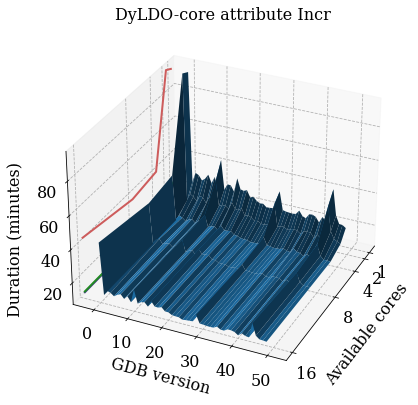

157.42671666666666
41


[(18, 'indianred'), (36, 'darkslateblue'), (41, 'forestgreen')]

(18, 36, 41)

('indianred', 'darkslateblue', 'forestgreen')

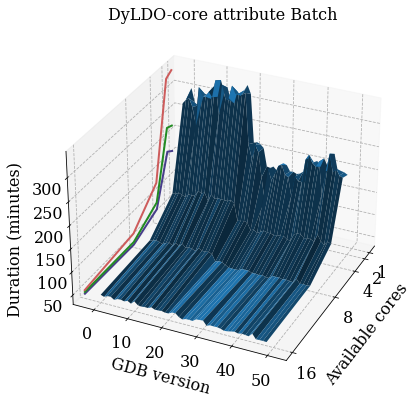

16.8978
22


[(15, 'indianred'), (22, 'forestgreen'), (40, 'darkslateblue')]

(15, 22, 40)

('indianred', 'forestgreen', 'darkslateblue')

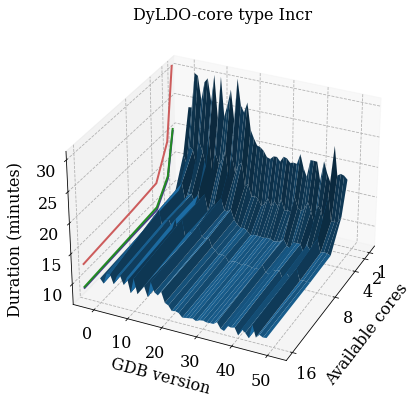

878.9196833333333
21


[(10, 'indianred'), (21, 'forestgreen'), (36, 'darkslateblue')]

(10, 21, 36)

('indianred', 'forestgreen', 'darkslateblue')

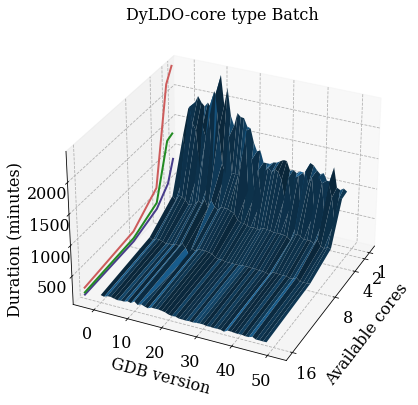

19.877266666666667
9


[(0, 'indianred'), (9, 'forestgreen'), (40, 'darkslateblue')]

(0, 9, 40)

('indianred', 'forestgreen', 'darkslateblue')

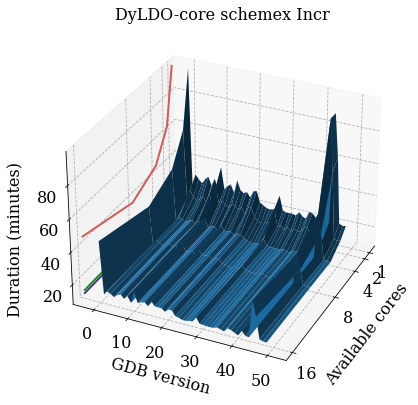

131.38186666666667
37


[(10, 'indianred'), (36, 'darkslateblue'), (37, 'forestgreen')]

(10, 36, 37)

('indianred', 'darkslateblue', 'forestgreen')

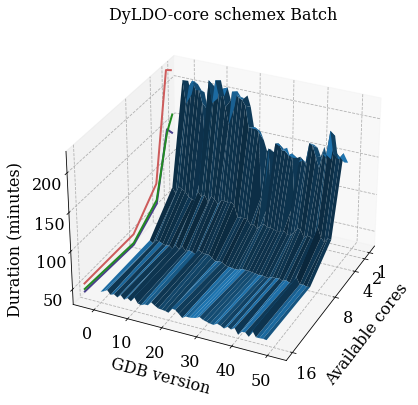

In [11]:
plot_dyldo(performance_frame)

In [37]:
hide_legend = False
performance_frame, run_details_frame = get_bsbm()
display(performance_frame.shape)

collect BSBM-attribute-parallel_1-test-2 from logs
Adding 41 entries
collect BSBM-attribute-parallel_2-test-2 from logs
Adding 41 entries
collect BSBM-attribute-parallel_4-test-2 from logs
Adding 41 entries
collect BSBM-attribute-parallel_8-test-2 from logs
Adding 41 entries
collect BSBM-attribute-parallel_16-test-2 from logs
Adding 41 entries
collect BSBM-schemex-parallel_1-test-2 from logs
Adding 41 entries
collect BSBM-schemex-parallel_2-test-2 from logs
Adding 41 entries
collect BSBM-schemex-parallel_4-test-2 from logs
Adding 41 entries
collect BSBM-schemex-parallel_8-test-2 from logs
Adding 41 entries
collect BSBM-schemex-parallel_16-test-2 from logs
Adding 41 entries
collect BSBM-type-parallel_1-test-2 from logs
Adding 41 entries
collect BSBM-type-parallel_2-test-2 from logs
Adding 41 entries
collect BSBM-type-parallel_4-test-2 from logs
Adding 41 entries
collect BSBM-type-parallel_8-test-2 from logs
Adding 41 entries
collect BSBM-type-parallel_16-test-2 from logs
Adding 41 entri

(41, 30)

In [58]:
performance_frame

,attribute-parallel_1-Inc,attribute-parallel_1-Batch,attribute-parallel_2-Inc,attribute-parallel_2-Batch,attribute-parallel_4-Inc,attribute-parallel_4-Batch,attribute-parallel_8-Inc,attribute-parallel_8-Batch,attribute-parallel_16-Inc,attribute-parallel_16-Batch,...,schemex-parallel_1-Inc,schemex-parallel_1-Batch,schemex-parallel_2-Inc,schemex-parallel_2-Batch,schemex-parallel_4-Inc,schemex-parallel_4-Batch,schemex-parallel_8-Inc,schemex-parallel_8-Batch,schemex-parallel_16-Inc,schemex-parallel_16-Batch
Iteration,,,,,,,,,,,,,,,,,,,,,
0,92.857167,283.901700,95.112483,283.088183,39.834633,106.987850,37.096467,54.417700,43.252483,46.691500,...,98.054533,206.234683,63.154017,214.155250,45.355550,85.436567,36.534833,45.070883,45.761983,44.293317
1,25.812483,305.867783,17.379867,292.061767,12.174217,107.851033,12.276383,55.475617,12.194617,43.912917,...,25.913683,189.156700,19.602433,183.656117,12.919417,78.111217,13.269083,42.087783,13.535433,46.122817
2,31.759583,275.939233,22.008100,296.629633,15.491433,112.289467,15.663150,58.446567,15.232383,47.556050,...,32.016283,207.397500,25.807917,208.172267,15.638283,88.576617,16.081567,47.431783,15.827967,48.791250
3,30.771333,271.406067,20.651500,279.241017,14.719383,109.025450,16.397883,55.528250,14.518000,47.938517,...,29.576683,204.467800,21.691667,216.158983,14.616800,86.042883,15.257333,46.838550,14.889667,43.700750
4,27.845867,277.382283,18.527233,239.947183,13.056583,106.222317,13.591733,53.378167,12.988733,43.012300,...,27.367167,197.776500,19.955900,204.648283,13.642883,83.734733,13.608033,44.743133,13.354933,45.593867
5,29.476383,299.970833,22.170250,325.508950,14.488583,113.761633,14.563517,57.456933,14.411433,46.707033,...,30.431500,195.679017,21.328400,206.799567,14.659900,77.652333,15.072950,43.354483,15.205300,42.558633
6,32.439500,298.442533,21.576917,307.210883,15.216233,113.066167,15.048317,60.007667,15.292417,47.288000,...,32.548750,172.691283,23.831533,189.909500,15.759550,75.275067,15.858950,44.555717,16.186583,46.796717
7,27.569767,291.754883,18.407150,308.179867,13.359083,114.828350,13.273800,55.684050,12.965433,45.499667,...,27.361633,171.903683,20.383517,117.367333,13.621783,74.502533,14.434450,40.725817,13.961967,41.806150
8,31.933767,321.128750,23.121133,319.848700,15.291900,126.312883,15.094083,63.069683,15.085733,48.531183,...,32.241917,205.936483,25.714000,221.137917,16.186883,87.688733,16.069983,47.228367,16.264333,45.060933


0.20685
10


[(10, 'forestgreen'), (20, 'indianred'), (40, 'darkslateblue')]

(10, 20, 40)

('forestgreen', 'indianred', 'darkslateblue')

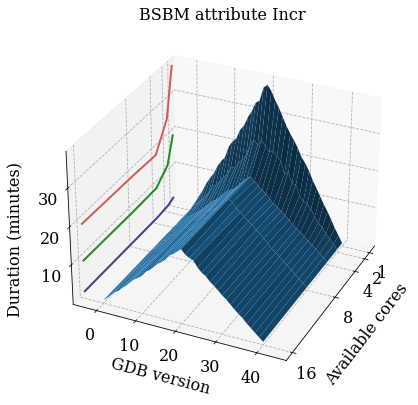

0.21413333333333334
10


[(10, 'forestgreen'), (20, 'indianred'), (40, 'darkslateblue')]

(10, 20, 40)

('forestgreen', 'indianred', 'darkslateblue')

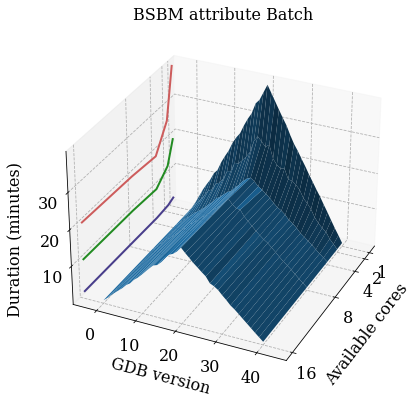

0.31215
10


[(0, 'darkslateblue'), (10, 'forestgreen'), (16, 'indianred')]

(0, 10, 16)

('darkslateblue', 'forestgreen', 'indianred')

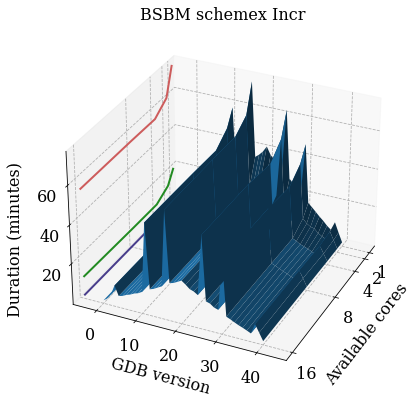

0.26616666666666666
10


[(10, 'forestgreen'), (20, 'indianred'), (40, 'darkslateblue')]

(10, 20, 40)

('forestgreen', 'indianred', 'darkslateblue')

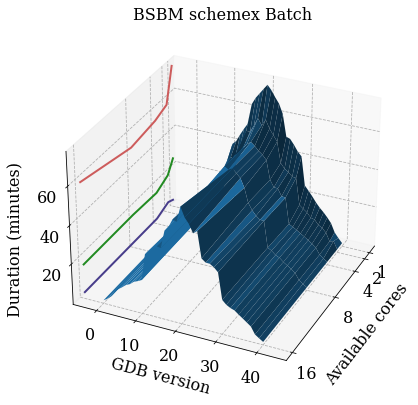

0.19208333333333333
30


[(20, 'indianred'), (30, 'forestgreen'), (40, 'darkslateblue')]

(20, 30, 40)

('indianred', 'forestgreen', 'darkslateblue')

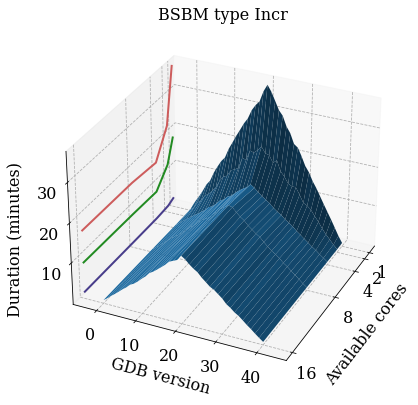

0.2067166666666667
10


[(10, 'forestgreen'), (20, 'indianred'), (40, 'darkslateblue')]

(10, 20, 40)

('forestgreen', 'indianred', 'darkslateblue')

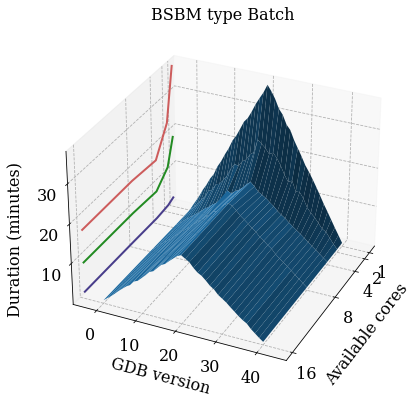

In [41]:
plot_bsbm(performance_frame)

In [56]:
start_iter = 0
end_iter = len(performance_frame)

for collection in collections:
    for parallization in parallizations:
        diff_frame = (performance_frame['%s-%s-Inc' % (collection, parallization)] - performance_frame['%s-%s-Batch' % (collection, parallization)]).abs()
        print('Difference between incr. and batch of %s in %s min: %s ' % (collection, parallization, diff_frame.min()))
        print('Difference between incr. and batch of %s in %s max: %s ' % (collection, parallization, diff_frame.max()))
        print('Difference between incr. and batch of %s in %s mean: %s ' % (collection, parallization, diff_frame.mean()))
        print('Difference between incr. and batch of %s in %s std: %s ' % (collection, parallization, diff_frame.std()))
        print('-----')
    

    


Difference between incr. and batch of attribute in parallel_1 min: 0.007283333333333336 
Difference between incr. and batch of attribute in parallel_1 max: 1.5407499999999956 
Difference between incr. and batch of attribute in parallel_1 mean: 0.478921138211382 
Difference between incr. and batch of attribute in parallel_1 std: 0.45246621921212626 
-----
Difference between incr. and batch of attribute in parallel_2 min: 0.01636666666666664 
Difference between incr. and batch of attribute in parallel_2 max: 3.3143333333333374 
Difference between incr. and batch of attribute in parallel_2 mean: 0.84464837398374 
Difference between incr. and batch of attribute in parallel_2 std: 0.8053548334844308 
-----
Difference between incr. and batch of attribute in parallel_4 min: 0.007533333333333336 
Difference between incr. and batch of attribute in parallel_4 max: 0.7874499999999998 
Difference between incr. and batch of attribute in parallel_4 mean: 0.32526219512195115 
Difference between incr.

In [14]:
def deduplicate(input_list):
    seen = set()
    new_list = []
    for item in input_list:
        if item not in seen:
            new_list.append(item)
            seen.add(item)
    return new_list


In [73]:
my_para = {}
for para in parallizations:
    my_para[para] = [x for x in performance_frame.columns if x.endswith('%s-Inc' % para)]

for para in parallizations:
    print('%s: incremental min: %s ' % (para, performance_frame.loc[1:, my_para[para]].min().min()))
    print('%s: incremental max: %s ' % (para, performance_frame.loc[1:, my_para[para]].max().max()))
    print('%s: incremental mean: %s ' % (para, performance_frame.loc[1:, my_para[para]].mean().mean()))
    print('%s: incremental std: %s ' % (para, performance_frame.loc[1:, my_para[para]].std().mean()))

parallel_1: incremental min: 16.8978 
parallel_1: incremental max: 89.40429999999999 
parallel_1: incremental mean: 25.059942824074074 
parallel_1: incremental std: 7.183349581117831 
parallel_2: incremental min: 10.496116666666667 
parallel_2: incremental max: 89.7262 
parallel_2: incremental mean: 17.891954976851853 
parallel_2: incremental std: 6.577650772891912 
parallel_4: incremental min: 7.616833333333333 
parallel_4: incremental max: 38.61685 
parallel_4: incremental mean: 11.732277314814816 
parallel_4: incremental std: 3.0913553244546725 
parallel_8: incremental min: 7.496333333333333 
parallel_8: incremental max: 29.318550000000002 
parallel_8: incremental mean: 11.50981400462963 
parallel_8: incremental std: 2.594068961933439 
parallel_16: incremental min: 7.095983333333334 
parallel_16: incremental max: 33.16125 
parallel_16: incremental mean: 11.411996990740741 
parallel_16: incremental std: 2.737653654909798 


In [94]:
# some speed-up analysis
#display(performance_frame)
speed_up_frame = pd.DataFrame(columns=deduplicate([x.replace('-Inc', '').replace('-Batch', '') for x in performance_frame.columns]))
collections = ['attribute', 'schemex', 'type'] #, 
parallizations = ['parallel_1', 'parallel_2', 'parallel_4', 'parallel_8', 'parallel_16']
for collection in collections:
    for parallelization in parallizations:
        speed_up_frame[collection+'-'+parallelization] = performance_frame[collection+'-'+parallelization+'-Batch'] /performance_frame[collection+'-'+parallelization+'-Inc']
        print('batch runs faster than incremental for %s: %s' % (collection+'-'+parallelization, (speed_up_frame[collection+'-'+parallelization] < 1.0).sum()))


print('-----')
print('Mean:')
display(speed_up_frame.mean())
print('Std:')
display(speed_up_frame.std())   
print('Min:')
display(speed_up_frame.min())
print('Max:')
display(speed_up_frame.max()) 
print('-----')

display(speed_up_frame.mean().mean())
display(speed_up_frame.std().mean())    
display(speed_up_frame.min().min())
display(speed_up_frame.max().max())  

batch runs faster than incremental for attribute-parallel_1: 0
batch runs faster than incremental for attribute-parallel_2: 0
batch runs faster than incremental for attribute-parallel_4: 0
batch runs faster than incremental for attribute-parallel_8: 0
batch runs faster than incremental for attribute-parallel_16: 0
batch runs faster than incremental for schemex-parallel_1: 0
batch runs faster than incremental for schemex-parallel_2: 0
batch runs faster than incremental for schemex-parallel_4: 0
batch runs faster than incremental for schemex-parallel_8: 0
batch runs faster than incremental for schemex-parallel_16: 1
batch runs faster than incremental for type-parallel_1: 0
batch runs faster than incremental for type-parallel_2: 0
batch runs faster than incremental for type-parallel_4: 0
batch runs faster than incremental for type-parallel_8: 0
batch runs faster than incremental for type-parallel_16: 0
-----
Mean:


attribute-parallel_1      9.351151
attribute-parallel_2     13.479793
attribute-parallel_4      7.622119
attribute-parallel_8      4.014830
attribute-parallel_16     3.709551
type-parallel_1          64.516358
type-parallel_2          77.823218
type-parallel_4          44.076995
type-parallel_8          21.478231
type-parallel_16         14.055382
schemex-parallel_1        6.258203
schemex-parallel_2        8.431542
schemex-parallel_4        5.491071
schemex-parallel_8        3.074087
schemex-parallel_16       3.262901
dtype: float64

Std:


attribute-parallel_1      1.811439
attribute-parallel_2      3.212168
attribute-parallel_4      1.325574
attribute-parallel_8      0.556996
attribute-parallel_16     0.662938
type-parallel_1           7.702295
type-parallel_2          20.288294
type-parallel_4           4.452042
type-parallel_8           2.225683
type-parallel_16          1.397660
schemex-parallel_1        1.226168
schemex-parallel_2        2.144893
schemex-parallel_4        1.013582
schemex-parallel_8        0.469467
schemex-parallel_16       0.675312
dtype: float64

Min:


attribute-parallel_1      3.057402
attribute-parallel_2      2.976352
attribute-parallel_4      2.685800
attribute-parallel_8      1.466924
attribute-parallel_16     1.079510
type-parallel_1          51.524308
type-parallel_2          43.306733
type-parallel_4          34.183643
type-parallel_8          12.212284
type-parallel_16         11.445055
schemex-parallel_1        1.957694
schemex-parallel_2        2.107483
schemex-parallel_4        1.883707
schemex-parallel_8        1.233641
schemex-parallel_16       0.967906
dtype: float64

Max:


attribute-parallel_1      13.253732
attribute-parallel_2      20.479629
attribute-parallel_4      10.115095
attribute-parallel_8       5.019106
attribute-parallel_16      4.924453
type-parallel_1           85.891820
type-parallel_2          120.108442
type-parallel_4           56.129356
type-parallel_8           25.382556
type-parallel_16          17.366669
schemex-parallel_1         7.443377
schemex-parallel_2        11.229374
schemex-parallel_4         6.541842
schemex-parallel_8         3.539549
schemex-parallel_16        4.211889
dtype: float64

-----


19.109695490196216

3.277634028292466

0.9679064026581017

120.10844190206804

In [81]:
speed_up_frame.head()

,attribute-parallel_1,attribute-parallel_2,attribute-parallel_4,attribute-parallel_8,attribute-parallel_16,type-parallel_1,type-parallel_2,type-parallel_4,type-parallel_8,type-parallel_16,schemex-parallel_1,schemex-parallel_2,schemex-parallel_4,schemex-parallel_8,schemex-parallel_16
Iteration,,,,,,,,,,,,,,,
0,3.057402,2.976352,2.685800,1.466924,1.079510,73.413949,81.965301,53.750121,24.465709,15.016364,2.103265,3.391000,1.883707,1.233641,0.967906
1,11.849607,16.804603,8.858971,4.518889,3.601008,68.129252,56.936340,47.379211,22.378118,14.712044,7.299491,9.369047,6.046033,3.171868,3.407561
2,8.688377,13.478203,7.248488,3.731470,3.122036,62.529655,101.275448,46.061665,21.624788,14.591574,6.477876,8.066217,5.664088,2.949450,3.082597
3,8.820094,13.521585,7.406931,3.386306,3.302006,67.197138,89.369433,41.072435,19.477073,14.673850,6.913142,9.965070,5.886575,3.069904,2.934972
4,9.961345,12.951053,8.135537,3.927252,3.311508,73.797327,97.095452,47.660510,23.313914,15.467841,7.226780,10.255027,6.137613,3.287994,3.414009


In [93]:
start_iter = 0
end_iter = len(performance_frame)

for collection in collections:
    t_frame = pd.DataFrame(columns=collections)
    for parallization in parallizations:
        t_frame['%s' % (collection)] = t_frame['%s' % (collection)].append(speed_up_frame['%s-%s' % (collection, parallization)], ignore_index=True)
    
    #display(t_frame)
    print('Speed-up incr. and batch of in %s min: %s ' % (collection, t_frame.loc[1:, '%s' % (collection)].min()))
    print('Speed-up incr. and batch of in %s max: %s ' % (collection, t_frame.loc[1:, '%s' % (collection)].max()))
    print('Speed-up incr. and batch of in %s mean: %s ' % (collection, t_frame.loc[1:, '%s' % (collection)].mean()))
    print('Speed-up incr. and batch of in %s std: %s ' % (collection, t_frame.loc[1:, '%s' % (collection)].std()))
    print('-----')

Speed-up incr. and batch of in attribute min: 5.510797746800279 
Speed-up incr. and batch of in attribute max: 13.253731877918167 
Speed-up incr. and batch of in attribute mean: 9.482270734299641 
Speed-up incr. and batch of in attribute std: 1.5782184261576238 
-----
Speed-up incr. and batch of in schemex min: 1.957694055729609 
Speed-up incr. and batch of in schemex max: 7.443376892510702 
Speed-up incr. and batch of in schemex mean: 6.344764362174117 
Speed-up incr. and batch of in schemex std: 1.0772730034642286 
-----
Speed-up incr. and batch of in type min: 51.524308232234254 
Speed-up incr. and batch of in type max: 85.8918201737624 
Speed-up incr. and batch of in type mean: 64.33099170246236 
Speed-up incr. and batch of in type std: 7.672554660696824 
-----


In [32]:
start_iter = 0
end_iter = len()

for collection in collections:
    print('%s min: %s ' % (collection, 
                           speed_up_frame.loc[:, '%s-%s' % (collection, parallizations[0]):
                                              '%s-%s' % (collection, parallizations[-1])].min().min()))
    print('%s max: %s ' % (collection, 
                           speed_up_frame.loc[:, '%s-%s' % (collection, parallizations[0]):
                                              '%s-%s' % (collection, parallizations[-1])].max().max()))
    
    print('%s mean: %s ' % (collection, 
                           speed_up_frame.loc[:, '%s-%s' % (collection, parallizations[0]):
                                              '%s-%s' % (collection, parallizations[-1])].mean().mean()))
    
    print('%s std: %s ' % (collection, 
                           speed_up_frame.loc[:, '%s-%s' % (collection, parallizations[0]):
                                              '%s-%s' % (collection, parallizations[-1])].std().std()))
        

attribute min: 1.079510270893887 
attribute max: 20.47962853231442 
attribute mean: 7.6354887707748675 
attribute std: 1.0779508159579416 
schemex min: 0.9679064026581017 
schemex max: 11.229374188451725 
schemex mean: 5.30356083597771 
schemex std: 0.6505661103131817 
type min: 11.445055092080862 
type max: 120.10844190206804 
type mean: 44.39003686383608 
type std: 7.705795291545356 


In [16]:
parallelization_frame = pd.DataFrame()
for collection in collections:
    for parallization in parallizations:
        try:
            print('[%s] %s Batch Algorithm - mean run time: %.4f' % (collection, parallization, performance_frame[collection+'-'+parallization+'-Batch'].mean()))
            print('[%s] %s Batch Algorithm - std run time: %.4f' % (collection, parallization, performance_frame[collection+'-'+parallization+'-Batch'].std()))
            print('[%s] %s Batch Algorithm - min run time: %.4f' % (collection, parallization, performance_frame[collection+'-'+parallization+'-Batch'].min()))
            print('[%s] %s Batch Algorithm - max run time: %.4f' % (collection, parallization, performance_frame[collection+'-'+parallization+'-Batch'].max()))
            
            print('[%s] %s Incremental Algorithm - mean run time: %.4f' % (collection, parallization, performance_frame[collection+'-'+parallization+'-Inc'].mean()))
            print('[%s] %s Incremental Algorithm - std run time: %.4f' % (collection, parallization, performance_frame[collection+'-'+parallization+'-Inc'].std()))
            print('[%s] %s Incremental Algorithm - min run time: %.4f' % (collection, parallization, performance_frame[collection+'-'+parallization+'-Inc'].min()))
            print('[%s] %s Incremental Algorithm - max run time: %.4f' % (collection, parallization, performance_frame[collection+'-'+parallization+'-Inc'].max()))
        except:
            pass

[attribute] parallel_1 Batch Algorithm - mean run time: 237.2615
[attribute] parallel_1 Batch Algorithm - std run time: 60.0730
[attribute] parallel_1 Batch Algorithm - min run time: 157.4267
[attribute] parallel_1 Batch Algorithm - max run time: 337.9403
[attribute] parallel_1 Incremental Algorithm - mean run time: 26.4189
[attribute] parallel_1 Incremental Algorithm - std run time: 11.1627
[attribute] parallel_1 Incremental Algorithm - min run time: 18.5075
[attribute] parallel_1 Incremental Algorithm - max run time: 92.8572
[attribute] parallel_2 Batch Algorithm - mean run time: 239.4884
[attribute] parallel_2 Batch Algorithm - std run time: 66.6135
[attribute] parallel_2 Batch Algorithm - min run time: 108.9263
[attribute] parallel_2 Batch Algorithm - max run time: 347.3882
[attribute] parallel_2 Incremental Algorithm - mean run time: 19.2441
[attribute] parallel_2 Incremental Algorithm - std run time: 12.0466
[attribute] parallel_2 Incremental Algorithm - min run time: 12.5878
[at

batch runs faster than incremental for schemex-parallel_2: 0
batch runs faster than incremental for schemex-parallel_4: 0
batch runs faster than incremental for schemex-parallel_8: 0
batch runs faster than incremental for schemex-parallel_16: 1

schemex-parallel_2     8.431542
schemex-parallel_4     5.491071
schemex-parallel_8     3.074087
schemex-parallel_16    3.262901
dtype: float64

schemex-parallel_2     2.144893
schemex-parallel_4     1.013582
schemex-parallel_8     0.469467
schemex-parallel_16    0.675312
dtype: float64

3.0740870579786934

8.431541932052054


batch runs faster than incremental for type-parallel_1: 0
batch runs faster than incremental for type-parallel_2: 0
batch runs faster than incremental for type-parallel_4: 0
batch runs faster than incremental for type-parallel_8: 0
batch runs faster than incremental for type-parallel_16: 0

type-parallel_1     64.516358
type-parallel_2     77.823218
type-parallel_4     44.076995
type-parallel_8     21.478231
type-parallel_16    14.055382
dtype: float64

type-parallel_1      7.702295
type-parallel_2     20.288294
type-parallel_4      4.452042
type-parallel_8      2.225683
type-parallel_16     1.397660
dtype: float64

14.055382052473432

77.82321756140654



batch runs faster than incremental for attribute-parallel_1: 0
batch runs faster than incremental for attribute-parallel_2: 0
batch runs faster than incremental for attribute-parallel_4: 0
batch runs faster than incremental for attribute-parallel_8: 1
batch runs faster than incremental for attribute-parallel_16: 3

attribute-parallel_1     1.440052
attribute-parallel_2     1.826764
attribute-parallel_4     1.464468
attribute-parallel_8     1.162826
attribute-parallel_16    1.068840
dtype: float64

attribute-parallel_1     0.050394
attribute-parallel_2     0.304808
attribute-parallel_4     0.081707
attribute-parallel_8     0.049375
attribute-parallel_16    0.042953
dtype: float64

1.0688399013235144

1.8267636241144851

In [125]:
t1 = (performance_frame['attribute-parallel_1-Batch'] /performance_frame['attribute-parallel_1-Inc']).mean()
t2 = (performance_frame['attribute-parallel_1-Batch'].sum() /performance_frame['attribute-parallel_1-Inc'].sum())

In [126]:
display(t1)
display(t2)

1.0184087697173205

1.0216032779598676

In [17]:
for collection in collections:
    for parallelization in parallizations:
        macro_avg = (performance_frame['%s-%s-Batch' % (collection, parallelization)] / performance_frame['%s-%s-Inc'  % (collection, parallelization)]).mean()
        macro_std = (performance_frame['%s-%s-Batch' % (collection, parallelization)] / performance_frame['%s-%s-Inc'  % (collection, parallelization)]).std()
        micro_avg = (performance_frame['%s-%s-Batch' % (collection, parallelization)].sum() / performance_frame['%s-%s-Inc'  % (collection, parallelization)].sum())
        print('[%s] %s - Micro Avg: %s' % (collection, parallelization, micro_avg.round(2)))
        print('[%s] %s - Macro Avg: %s' % (collection, parallelization, macro_avg.round(2)))
        print('[%s] %s - Macro std: %s' % (collection, parallelization, macro_std.round(2)))

[attribute] parallel_1 - Micro Avg: 8.98
[attribute] parallel_1 - Macro Avg: 9.35
[attribute] parallel_1 - Macro std: 1.81
[attribute] parallel_2 - Micro Avg: 12.44
[attribute] parallel_2 - Macro Avg: 13.48
[attribute] parallel_2 - Macro std: 3.21
[attribute] parallel_4 - Micro Avg: 7.38
[attribute] parallel_4 - Macro Avg: 7.62
[attribute] parallel_4 - Macro std: 1.33
[attribute] parallel_8 - Micro Avg: 3.89
[attribute] parallel_8 - Macro Avg: 4.01
[attribute] parallel_8 - Macro std: 0.56
[attribute] parallel_16 - Micro Avg: 3.48
[attribute] parallel_16 - Macro Avg: 3.71
[attribute] parallel_16 - Macro std: 0.66
[schemex] parallel_1 - Micro Avg: 5.71
[schemex] parallel_1 - Macro Avg: 6.26
[schemex] parallel_1 - Macro std: 1.23
[schemex] parallel_2 - Micro Avg: 7.55
[schemex] parallel_2 - Macro Avg: 8.43
[schemex] parallel_2 - Macro std: 2.14
[schemex] parallel_4 - Micro Avg: 5.07
[schemex] parallel_4 - Macro Avg: 5.49
[schemex] parallel_4 - Macro std: 1.01
[schemex] parallel_8 - Micro 

In [28]:
# print((all_frame['batch'] / all_frame['incr']).mean())
# print(all_frame['batch'].sum() / all_frame['incr'].sum())

In [29]:
for col in performance_frame.columns:
    if 'parallel_1-Inc' in col:
        #baseline
        baseline = performance_frame[col]
    elif '-Batch' in col:
        print('%s has faster runs than baseline? %s' % (col, (performance_frame[col] - baseline < 0).sum()))
        

attribute-parallel_1-Batch has faster runs than baseline? 0
attribute-parallel_2-Batch has faster runs than baseline? 0
attribute-parallel_4-Batch has faster runs than baseline? 0
attribute-parallel_8-Batch has faster runs than baseline? 1
attribute-parallel_16-Batch has faster runs than baseline? 1
type-parallel_1-Batch has faster runs than baseline? 0
type-parallel_2-Batch has faster runs than baseline? 0
type-parallel_4-Batch has faster runs than baseline? 0
type-parallel_8-Batch has faster runs than baseline? 0
type-parallel_16-Batch has faster runs than baseline? 0


In [18]:
parallelization_frame = pd.DataFrame()
for collection in collections:
    for i in range(1, len(parallizations)):
        prev = parallizations[i-1]
        current = parallizations[i]
        parallelization_frame[collection+'-'+current+'-Batch'] = performance_frame[collection+'-'+prev+'-Batch'] / performance_frame[collection+'-'+current+'-Batch'] 
        parallelization_frame[collection+'-'+current+'-Inc'] = performance_frame[collection+'-'+prev+'-Inc'] / performance_frame[collection+'-'+current+'-Inc'] 
            
display(parallelization_frame.mean())
display(parallelization_frame.std())

attribute-parallel_2-Batch     1.004828
attribute-parallel_2-Inc       1.421828
attribute-parallel_4-Batch     2.601937
attribute-parallel_4-Inc       1.501395
attribute-parallel_8-Batch     1.903802
attribute-parallel_8-Inc       1.007920
attribute-parallel_16-Batch    1.092540
attribute-parallel_16-Inc      0.990002
schemex-parallel_2-Batch       1.018081
schemex-parallel_2-Inc         1.334516
schemex-parallel_4-Batch       2.379082
schemex-parallel_4-Inc         1.569864
schemex-parallel_8-Batch       1.784693
schemex-parallel_8-Inc         1.010369
schemex-parallel_16-Batch      0.942886
schemex-parallel_16-Inc        0.985135
type-parallel_2-Batch          1.363527
type-parallel_2-Inc            1.538961
type-parallel_4-Batch          2.553116
type-parallel_4-Inc            1.443578
type-parallel_8-Batch          2.144589
type-parallel_8-Inc            1.034889
type-parallel_16-Batch         1.636900
type-parallel_16-Inc           1.067712
dtype: float64

attribute-parallel_2-Batch     0.115668
attribute-parallel_2-Inc       0.103813
attribute-parallel_4-Batch     0.256525
attribute-parallel_4-Inc       0.172909
attribute-parallel_8-Batch     0.107215
attribute-parallel_8-Inc       0.042330
attribute-parallel_16-Batch    0.170493
attribute-parallel_16-Inc      0.039810
schemex-parallel_2-Batch       0.198128
schemex-parallel_2-Inc         0.100860
schemex-parallel_4-Batch       0.337350
schemex-parallel_4-Inc         0.171544
schemex-parallel_8-Batch       0.087496
schemex-parallel_8-Inc         0.078455
schemex-parallel_16-Batch      0.077098
schemex-parallel_16-Inc        0.046877
type-parallel_2-Batch          0.396059
type-parallel_2-Inc            0.083247
type-parallel_4-Batch          0.642576
type-parallel_4-Inc            0.086638
type-parallel_8-Batch          0.371587
type-parallel_8-Inc            0.022324
type-parallel_16-Batch         0.133371
type-parallel_16-Inc           0.032182
dtype: float64

In [33]:
# overall gain:
skip_rows = 1
for collection in collections:
    try:
        t_frame = performance_frame[collection+'-parallel_1-Batch'] / performance_frame[collection+'-parallel_16-Batch']
        print('[%s] Speed-up batch 1 to 16 between %.4f and %.4f (mean: %.4f +- %.4f)' % (collection, t_frame.min(), t_frame.max(), t_frame.mean(), t_frame.std()))


        t_frame = performance_frame.iloc[skip_rows:][collection+'-parallel_1-Inc'] / performance_frame.iloc[skip_rows:][collection+'-parallel_16-Inc']
        print('[%s] Speed-up incr. 1 to 16 between %.4f and %.4f (mean: %.4f +- %.4f)' % (collection, t_frame.min(), t_frame.max(), t_frame.mean(), t_frame.std()))
    except:
        pass

[attribute] Speed-up batch 1 to 16 between 3.7749 and 7.4025 (mean: 5.4239 +- 1.1460)
[attribute] Speed-up incr. 1 to 16 between 2.0087 and 2.2408 (mean: 2.1087 +- 0.0454)
[schemex] Speed-up batch 1 to 16 between 3.2018 and 5.1555 (mean: 3.9808 +- 0.5170)
[schemex] Speed-up incr. 1 to 16 between 1.9145 and 2.6960 (mean: 2.0633 +- 0.1404)
[type] Speed-up batch 1 to 16 between 10.4138 and 12.6591 (mean: 11.2199 +- 0.6263)
[type] Speed-up incr. 1 to 16 between 2.2922 and 2.5809 (mean: 2.4495 +- 0.0619)


In [36]:
# one core incr. vs 16 core batch

for collection in collections:
    try:
        t_frame = performance_frame.iloc[skip_rows:][collection+'-parallel_16-Batch'] / performance_frame.iloc[skip_rows:][collection+'-parallel_1-Inc']
        print(collection)
        display(t_frame)
        print('[%s] Speed-up incr. 1 to batch 16 between %.4f and %.4f (mean: %.4f +- %.4f)' % (collection, t_frame.min(), t_frame.max(), t_frame.mean(), t_frame.std()))
    except:
        pass


attribute


Iteration
1     1.701228
2     1.497376
3     1.557895
4     1.544657
5     1.584558
6     1.457729
7     1.650346
8     1.519745
9     1.778836
10    1.180110
11    1.771627
12    1.500878
13    1.543402
14    1.744028
15    1.397841
16    1.605367
17    1.643862
18    1.616542
19    1.816066
20    1.767201
23    2.092628
24    2.235718
25    1.915891
26    1.907835
27    2.038340
28    2.020274
29    1.954083
30    1.459847
31    2.266254
32    2.357129
33    1.915730
34    2.081002
35    2.028916
36    1.814523
37    2.013536
38    1.969602
39    1.745709
40    1.800363
41    1.947988
42    2.153250
43    1.863284
44    2.013763
45    1.986061
46    1.154926
47    1.483064
48    1.842073
49    1.861543
50    1.978745
dtype: float64

[attribute] Speed-up incr. 1 to batch 16 between 1.1549 and 2.3571 (mean: 1.7871 +- 0.2676)
schemex


Iteration
1     1.779863
2     1.523951
3     1.477541
4     1.666006
5     1.398506
6     1.437742
7     1.527911
8     1.397589
9     1.633738
10    1.205817
11    1.548560
12    1.381809
13    1.374893
14    1.641450
15    1.384628
16    1.554909
17    1.542503
18    1.462799
19    1.613064
20    1.336023
23    1.522376
24    1.936265
25    1.874557
26    1.785869
27    1.975055
28    1.919372
29    1.866717
30    1.375226
31    2.030763
32    1.998572
33    1.936687
34    1.867833
35    1.900827
36    1.803000
37    1.932898
38    1.888980
39    1.664754
40    1.602344
41    1.899144
42    1.736345
43    1.367712
44    1.894814
45    1.664948
46    0.499731
47    0.589503
48    1.706445
49    1.809819
50    1.746960
dtype: float64

[schemex] Speed-up incr. 1 to batch 16 between 0.4997 and 2.0308 (mean: 1.6185 +- 0.3118)
type


Iteration
1     5.988187
2     5.653654
3     5.781191
4     6.120030
5     5.076994
6     5.174130
7     5.819401
8     5.621249
9     6.664050
10    6.518042
11    6.408388
12    6.933958
13    5.532315
14    6.050504
15    5.522787
16    6.347656
17    6.697784
18    5.929302
19    6.655661
20    5.978383
23    5.880432
24    6.137576
25    5.403134
26    5.608962
27    5.542835
28    5.632727
29    5.360498
30    5.898260
31    5.856400
32    5.876972
33    5.488233
34    5.557849
35    5.330738
36    4.999481
37    5.488519
38    4.902184
39    5.912745
40    5.778531
41    5.473608
42    6.283696
43    5.444113
44    5.430664
45    5.944523
46    5.202816
47    4.999268
48    4.927938
49    4.894171
50    5.085466
dtype: float64

[type] Speed-up incr. 1 to batch 16 between 4.8942 and 6.9340 (mean: 5.7253 +- 0.5079)


In [149]:
display(performance_frame.iloc[skip_rows:].mean())
display(performance_frame.iloc[skip_rows:].std())
display(performance_frame.iloc[skip_rows:].min())
display(performance_frame.iloc[skip_rows:].max())

attribute-parallel_1-Inc         25.034720
attribute-parallel_1-Batch      236.289836
attribute-parallel_2-Inc         17.663532
attribute-parallel_2-Batch      238.580033
attribute-parallel_4-Inc         11.834798
attribute-parallel_4-Batch       91.185660
attribute-parallel_8-Inc         11.764677
attribute-parallel_8-Batch       47.586828
attribute-parallel_16-Inc        11.856603
attribute-parallel_16-Batch      43.425791
type-parallel_1-Inc              22.384876
type-parallel_1-Batch          1455.942462
type-parallel_2-Inc              14.541830
type-parallel_2-Batch          1130.889084
type-parallel_4-Inc              10.104456
type-parallel_4-Batch           445.720995
type-parallel_8-Inc               9.752447
type-parallel_8-Batch           208.744115
type-parallel_16-Inc              9.108633
type-parallel_16-Batch          128.775465
schemex-parallel_2-Inc           21.470503
schemex-parallel_2-Batch        167.601806
schemex-parallel_4-Inc           13.257578
schemex-par

attribute-parallel_1-Inc         5.602179
attribute-parallel_1-Batch      60.318306
attribute-parallel_2-Inc         4.815577
attribute-parallel_2-Batch      67.011088
attribute-parallel_4-Inc         2.537381
attribute-parallel_4-Batch      22.230847
attribute-parallel_8-Inc         2.492596
attribute-parallel_8-Batch       9.716144
attribute-parallel_16-Inc        2.537572
attribute-parallel_16-Batch      3.626592
type-parallel_1-Inc              4.388741
type-parallel_1-Batch          399.671349
type-parallel_2-Inc              2.841528
type-parallel_2-Batch          379.118212
type-parallel_4-Inc              1.935380
type-parallel_4-Batch          105.724975
type-parallel_8-Inc              1.896315
type-parallel_8-Batch           45.640375
type-parallel_16-Inc             1.591550
type-parallel_16-Batch          30.296860
schemex-parallel_2-Inc          12.075848
schemex-parallel_2-Batch        36.004799
schemex-parallel_4-Inc           4.801305
schemex-parallel_4-Batch        10

attribute-parallel_1-Inc        18.507467
attribute-parallel_1-Batch     157.426717
attribute-parallel_2-Inc        12.587800
attribute-parallel_2-Batch     108.926283
attribute-parallel_4-Inc         8.780233
attribute-parallel_4-Batch      62.706933
attribute-parallel_8-Inc         8.787433
attribute-parallel_8-Batch      35.777183
attribute-parallel_16-Inc        8.809167
attribute-parallel_16-Batch     37.368867
type-parallel_1-Inc             16.897800
type-parallel_1-Batch          878.919683
type-parallel_2-Inc             10.496117
type-parallel_2-Batch          530.778150
type-parallel_4-Inc              7.616833
type-parallel_4-Batch          292.586000
type-parallel_8-Inc              7.496333
type-parallel_8-Batch          141.701367
type-parallel_16-Inc             7.095983
type-parallel_16-Batch          83.623167
schemex-parallel_2-Inc          14.150867
schemex-parallel_2-Batch        81.781000
schemex-parallel_4-Inc           9.630683
schemex-parallel_4-Batch        55

attribute-parallel_1-Inc         43.385167
attribute-parallel_1-Batch      337.940333
attribute-parallel_2-Inc         34.325000
attribute-parallel_2-Batch      347.388217
attribute-parallel_4-Inc         19.916200
attribute-parallel_4-Batch      126.312883
attribute-parallel_8-Inc         19.368483
attribute-parallel_8-Batch       65.100417
attribute-parallel_16-Inc        20.218383
attribute-parallel_16-Batch      51.199283
type-parallel_1-Inc              30.825183
type-parallel_1-Batch          2430.088917
type-parallel_2-Inc              21.111350
type-parallel_2-Batch          2199.764367
type-parallel_4-Inc              14.723467
type-parallel_4-Batch           658.433833
type-parallel_8-Inc              14.168517
type-parallel_8-Batch           310.730350
type-parallel_16-Inc             12.226450
type-parallel_16-Batch          199.199717
schemex-parallel_2-Inc           89.726200
schemex-parallel_2-Batch        222.692567
schemex-parallel_4-Inc           38.616850
schemex-par

In [18]:
mux = pd.MultiIndex.from_product([['1','2','4', '8', '16'], ['incr.','batch']])
df = pd.DataFrame(columns=mux)
df

Empty DataFrame
Columns: [(1, incr.), (1, batch), (2, incr.), (2, batch), (4, incr.), (4, batch), (8, incr.), (8, batch), (16, incr.), (16, batch)]
Index: []

In [19]:
latex_frame = performance_frame.copy()
latex_frame.columns = ['1 core incr.', '1 core batch',
                       '2 core incr.', '2 core batch',
                       '4 core incr.', '4 core batch',
                       '8 core incr.', '8 core batch',
                       '16 core incr.', '16 core batch']
latex_frame.columns = mux
latex_frame.index.rename('GDB Version', True)
latex_frame = latex_frame.round(2)
display(latex_frame.mean())

1   incr.    19.452683
    batch    28.027317
2   incr.    12.502927
    batch    23.224146
4   incr.     8.915366
    batch    13.210000
8   incr.     9.057317
    batch    10.567561
16  incr.    10.046341
    batch    10.737805
dtype: float64

In [20]:
print(latex_frame.to_latex())

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} & \multicolumn{2}{l}{1} & \multicolumn{2}{l}{2} & \multicolumn{2}{l}{4} & \multicolumn{2}{l}{8} & \multicolumn{2}{l}{16} \\
{} &  incr. &  batch &  incr. &  batch &  incr. &  batch &  incr. &  batch &  incr. &  batch \\
GDB Version &        &        &        &        &        &        &        &        &        &        \\
\midrule
0           &   0.30 &   0.42 &   0.22 &   0.24 &   0.15 &   0.16 &   0.16 &   0.14 &   0.18 &   0.16 \\
1           &   2.49 &   3.17 &   1.47 &   2.53 &   0.99 &   1.50 &   0.97 &   1.13 &   1.12 &   1.20 \\
2           &   4.18 &   5.72 &   2.61 &   5.35 &   1.90 &   2.66 &   1.88 &   2.28 &   2.06 &   2.38 \\
3           &   6.35 &   8.50 &   3.91 &   6.19 &   2.73 &   4.32 &   2.90 &   3.40 &   3.21 &   3.38 \\
4           &   8.06 &  11.32 &   4.88 &  12.45 &   3.62 &   5.50 &   3.65 &   4.31 &   4.34 &   4.29 \\
5           &   9.98 &  14.52 &   6.23 &  10.80 &   4.62 &   6.94 &   4.57 &   5.65 &   5.04 &   5.5

# run details


In [57]:
display(run_details_frame.head())

,attribute-parallel_1-Inc,attribute-parallel_1-Batch,attribute-parallel_1-Inc F&M,attribute-parallel_1-Batch F&M,attribute-parallel_2-Inc,attribute-parallel_2-Batch,attribute-parallel_2-Inc F&M,attribute-parallel_2-Batch F&M,attribute-parallel_4-Inc,attribute-parallel_4-Batch,...,type-parallel_4-Inc F&M,type-parallel_4-Batch F&M,type-parallel_8-Inc,type-parallel_8-Batch,type-parallel_8-Inc F&M,type-parallel_8-Batch F&M,type-parallel_16-Inc,type-parallel_16-Batch,type-parallel_16-Inc F&M,type-parallel_16-Batch F&M
Iteration,,,,,,,,,,,,,,,,,,,,,
0,92.857167,283.901700,69.597667,260.103333,95.112483,283.088183,79.320550,266.743000,39.834633,106.987850,...,2.185100,570.133167,11.355050,277.809350,2.969917,269.031733,10.675917,160.313450,3.057233,152.983833
1,25.812483,305.867783,2.958717,282.671833,17.379867,292.061767,3.319133,277.901133,12.174217,107.851033,...,2.338600,507.697317,10.762417,240.842633,2.344900,232.450850,9.950250,146.388517,2.736283,139.151417
2,31.759583,275.939233,4.654867,248.296017,22.008100,296.629633,5.182967,278.070567,15.491433,112.289467,...,2.813050,601.401667,13.035867,281.897850,3.023433,271.743733,11.729667,171.154300,3.144900,162.449583
3,30.771333,271.406067,3.472917,244.266283,20.651500,279.241017,4.353433,262.364583,14.719383,109.025450,...,2.783733,594.499717,14.168517,275.961233,2.828533,266.004133,11.784817,172.928633,3.221967,164.417917
4,27.845867,277.382283,3.457350,253.676700,18.527233,239.947183,4.116433,225.516167,13.056583,106.222317,...,2.569483,553.930967,11.267050,262.679033,2.559917,253.901550,10.292700,159.205850,2.865150,151.705683


In [19]:
find_and_merge_frame = pd.DataFrame()
for collection in collections:
    for i in range(0, len(parallizations)):
        current = parallizations[i]
        find_and_merge_frame[collection+'-'+current+'-Batch'] = run_details_frame[collection+'-'+current +'-Batch F&M'] / run_details_frame[collection+'-'+current+'-Batch'] 
        find_and_merge_frame[collection+'-'+current+'-Inc'] = run_details_frame[collection+'-'+current+'-Inc F&M'] / run_details_frame[collection+'-'+current+'-Inc'] 
            
display(find_and_merge_frame.mean())
display(find_and_merge_frame.std())

attribute-parallel_1-Batch     0.909583
attribute-parallel_1-Inc       0.167052
attribute-parallel_2-Batch     0.943794
attribute-parallel_2-Inc       0.260654
attribute-parallel_4-Batch     0.910360
attribute-parallel_4-Inc       0.326474
attribute-parallel_8-Batch     0.827826
attribute-parallel_8-Inc       0.314405
attribute-parallel_16-Batch    0.828406
attribute-parallel_16-Inc      0.377422
schemex-parallel_1-Batch       0.877318
schemex-parallel_1-Inc         0.248907
schemex-parallel_2-Batch       0.918676
schemex-parallel_2-Inc         0.343140
schemex-parallel_4-Batch       0.885642
schemex-parallel_4-Inc         0.375704
schemex-parallel_8-Batch       0.790908
schemex-parallel_8-Inc         0.354124
schemex-parallel_16-Batch      0.820978
schemex-parallel_16-Inc        0.430530
type-parallel_1-Batch          0.985200
type-parallel_1-Inc            0.064168
type-parallel_2-Batch          0.987828
type-parallel_2-Inc            0.121800
type-parallel_4-Batch          0.981991


attribute-parallel_1-Batch     0.011183
attribute-parallel_1-Inc       0.115721
attribute-parallel_2-Batch     0.011034
attribute-parallel_2-Inc       0.128815
attribute-parallel_4-Batch     0.009719
attribute-parallel_4-Inc       0.087064
attribute-parallel_8-Batch     0.013499
attribute-parallel_8-Inc       0.081093
attribute-parallel_16-Batch    0.021914
attribute-parallel_16-Inc      0.082160
schemex-parallel_1-Batch       0.009462
schemex-parallel_1-Inc         0.145738
schemex-parallel_2-Batch       0.020043
schemex-parallel_2-Inc         0.140783
schemex-parallel_4-Batch       0.008458
schemex-parallel_4-Inc         0.113196
schemex-parallel_8-Batch       0.015485
schemex-parallel_8-Inc         0.098419
schemex-parallel_16-Batch      0.023853
schemex-parallel_16-Inc        0.099323
type-parallel_1-Batch          0.001766
type-parallel_1-Inc            0.004455
type-parallel_2-Batch          0.003613
type-parallel_2-Inc            0.009264
type-parallel_4-Batch          0.001852


# other stuff

In [23]:
import numpy as np
import matplotlib.pyplot as plt




In [24]:
size_frame = pd.DataFrame()
for collection in collections:
    with open(os.path.join(data_dir, appname + '_'+collection+suffix+'-update-time-and-space.csv'), 'r') as f:
        df = pd.read_csv(f, sep=',')
        df.head()
        
        iterations = max(iterations, len(df['Iteration']))
        df = df.set_index('Iteration')

        if '|V|' not in size_frame:
            size_frame['|V|'] = df['Imprint links']
            
        size_frame[collection+':|V_vs|'] = df['Schema Elements (SE)']
        size_frame[collection+':|E_vs|'] = df['Schema Relations (SR)']


        
size_frame = size_frame.join(edgeframe,how='left')
display(size_frame.head())


NameError: name 'data_dir' is not defined

In [ ]:
display(size_frame['|V|'].min())
display(size_frame['|V|'].max())
display(size_frame['|V|'].mean())
display(size_frame['|V|'].std())

In [ ]:
size_frame.columns = ['|V|', 'SchemEX:|V_vs|','SchemEX:|E_vs|' 
                    , 'AttrColl:|V_vs|', 'AttrColl:|E_vs|'
                    , 'TypeColl:|V_vs|', 'TypeColl:|E_vs|', '|E|']

if appname == 'dyldo_y2019_core':
    if interpolate:
        size_frame = size_frame.drop(size_frame.index[[21,22]])
    else:
        size_frame.loc[21:22,'|V|':'|E|']=np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan
   

if appname == 'dyldo_y2019_full':
    size_frame = size_frame.head()
    iterations = 5
    ticks = 1.0
    print('drop the beat')
    
  
display(size_frame)

sorted_frame = size_frame[['SchemEX:|V_vs|', 'SchemEX:|E_vs|' 
                    , 'AttrColl:|V_vs|', 'AttrColl:|E_vs|'
                    , 'TypeColl:|V_vs|', 'TypeColl:|E_vs|', '|V|', '|E|']]

sorted_frame.columns=['SchemEX:$|V_{vs}|$', 'SchemEX:$|E_{vs}|$' 
                    , 'AttrColl:$|V_{vs}|$', 'AttrColl:$|E_{vs}|$'
                    , 'TypeColl:$|V_{vs}|$', 'TypeColl:$|E_{vs}|$', '$|V|$', '$|E|$']

ax = sorted_frame.plot(logy=True, style = ['--','-','--','-','--','-','--','-'], 
                       color=['darkslateblue', 'darkslateblue',
                             'forestgreen','forestgreen',
                             'indianred','indianred', 'dimgray', 'dimgray'])#,yticks=([math.exp(w) for w in np.arange(1, 10, 2)]))
#ax.set_ylim([2500, 80000])color=['dimgray', 'darkslateblue']
#plt.yticks(np.arange(0, iterations, 5.0))
#plt.
plt.xticks(np.arange(0, iterations, ticks))
ax.set_xlabel("GDB version")
ax.set_ylabel("Count")

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.325), shadow=True, ncol=3)
if hide_legend:
    ax.get_legend().remove()
    
plt.grid(True)
plt.savefig(out_dir + '/' + appname + '-sizes.pdf',  bbox_inches = 'tight')

In [ ]:
frames = [None, None, None]
i = 0
iterations = 0
for collection in collections:
    with open(os.path.join(data_dir, appname + '_'+collection+suffix+'-changes.csv'), 'r') as f:
        df = pd.read_csv(f, sep=',')
        df.head()

        #del df['NewlyObservedSchema (SE_new)']
        #del df['DeletedSchemaStructures (SE_del)']

        
        del df['TotalNumberOfNewInstances'] 
        del df['InstanceAddedWithKnownSchema (PE_add)']
        del df['InstancesDeleted (PE_del)']
        del df['ChangedSchemaStructuresBecauseOfNeighbor'] 
        del df['PayloadEntriesAdded'] 
        del df['PayloadEntriesRemoved'] 
        del df['InstanceToSchemaLinksAdded'] 
        del df['InstanceToSchemaLinksRemoved'] 

        del df['TotalNumberOfChangedPayloadElements (real PE_mod)']
        
        del df['TotalNumberOfSchemaElementsWritten']
        del df['TotalNumberOfSchemaElementsDeleted']
        #del df['InstanceNotChanged (PE_mod)']
        iterations = max(iterations, len(df['Iteration']))
        df = df.set_index('Iteration')
        print(df.columns)
        df.columns = [collection+'ADD', collection+'DEL', collection+'MOD', collection+'unchanged']    #'Modified pe(v)'
        
        #df.columns = [collection+'MOD-ELEM', collection+'Unchanged v', collection+'ADD-ELEM', collection+'DEL-ELEM']    #'Modified pe(v)'
        #df = df[[collection+'ADD-ELEM', collection+'DEL-ELEM', collection+'MOD-ELEM',collection+'Unchanged v']] #'Modified pe(v)'
        frames[i] = df
        i = i + 1
        
df = pd.concat(frames, sort=False)


df.columns = ['SchemEX:ADD', 'SchemEX:DEL', 'SchemEX:MOD','SchemEX:PAY',
             'AttrColl:ADD', 'AttrColl:DEL', 'AttrColl:MOD','AttrColl:PAY',
             'TypeColl:ADD', 'TypeColl:DEL', 'TypeColl:MOD','TypeColl:PAY']
ax = df.plot(logy=True, style = [':','-','--','-.',':','-','--','-.',':','-','--','-.'], 
             color=['darkslateblue', 'darkslateblue', 'darkslateblue', 'darkslateblue', 
                    'forestgreen', 'forestgreen', 'forestgreen','forestgreen',
                   'indianred', 'indianred', 'indianred','indianred'])
#ax.set_ylabel("Quantity")
#ax.yaxis.set_label_coords(-0.015,1.0)
plt.xticks(np.arange(0, iterations, 5.0))
ax.set_xlabel("GDB version")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.325), shadow=True, ncol=3)

if hide_legend:
    ax.get_legend().remove()

plt.grid(True)
plt.savefig(out_dir + '/' + appname + '-changes.png', bbox_inches = 'tight')

In [ ]:


    
        
performance_frame = pd.DataFrame() 
run_details_frame = pd.DataFrame()
for collection in collections:
#    new_zero_incr = 0
#    new_zero_batch = 0
    for parallelization in parallizations:
        load_data
#         # collectStatistics(analyze_app, event_dir='/tmp/spark-events', memory_dir='/tmp/spark-memory')   
#         print(appname+'-'+collection+'-'+parallelization+suffix)
#         df = collect_statistics(appname+'-'+collection+'-'+parallelization+suffix, 
#                                event_dir=event_dir, 
#                                memory_dir=memory_dir) 
#         display(df.head())
#         # BSBM-type-parallel_1-test-1
# #         app_exp_name = appname + '-'+collection+'-'+parallelization+suffix
# #         with open(os.path.join(exp_log_dir, app_exp_name, app_exp_name+'-performance.csv'), 'r') as f:
# #             df = pd.read_csv(f, sep=',')
# #             #display(df.head())
# #        iterations = max(iterations, len(df['Iteration']))
# #        df = df.set_index('Iteration')

#         performance_frame[collection+'-'+parallelization+'-Inc'] = df['Incremental Duration']
#         performance_frame[collection+'-'+parallelization+'-Batch'] = df['Batch Duration']

#         run_details_frame[collection+'-'+parallelization+'-Inc'] = df['Incremental Duration']
#         run_details_frame[collection+'-'+parallelization+'-Batch'] = df['Batch Duration']
#         run_details_frame[collection+'-'+parallelization+'-Inc F&M'] = df['Incremental F&M Duration']
#         run_details_frame[collection+'-'+parallelization+'-Batch F&M'] = df['Batch F&M Duration']        

    

#performance_frame.columns = ['SchemEX:Incr', 'SchemEX:Batch', 
#             'AttrColl:Incr', 'AttrColl:Batch',
#             'TypeColl:Incr', 'TypeColl:Batch']
 
convert = lambda x: x / 1000 / 60
performance_frame = performance_frame.applymap(convert)  
run_details_frame = run_details_frame.applymap(convert)

display(performance_frame.head())
display(run_details_frame.head())

if (appname == 'dyldo_y2019_core' or appname == 'DyLDO-core') and len(performance_frame) > 23:
    performance_frame = performance_frame.drop(performance_frame.index[[21,22]])
    run_details_frame = run_details_frame.drop(run_details_frame.index[[21,22]])
    
if appname == 'dyldo_y2019_full':
    performance_frame = performance_frame.head()
    run_details_frame = run_details_frame.head()
    iterations = 5
    ticks = 1.0
    print('drop the beat')